In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from glob import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib.gridspec as gridspec
from statsmodels.stats.anova import AnovaRM
%pylab
%matplotlib inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## FMRI REACTION TIMES

The purpose of this notebook is to analyse the button-press reaction times recorded during the fmri scans. Since the elicited activation profile can be influenced by participant's performance, we want to make sure that our participants' speed is consistent between pre and post scaning sessions.

In [2]:
path = '/Volumes/ritd-ag-project-rd00k9-tmaki67/'

## STIMULI ONSET FILES

In [3]:
stim1=load(path + '1-targ.npy')
stim2=load(path + '2-targ.npy')
stim3=load(path + '3-targ.npy')
stim4=load(path + '4-targ.npy')

restIndex1= numpy.where(stim1 == 'REST')
restIndex2= np.where(stim2 == 'REST')
restIndex3= np.where(stim3 == 'REST')
restIndex4= np.where(stim4 == 'REST')

First, we read in the stimulus data, which is the same for alll teh participants, and get rid of all the conditions that did not require a button press. This is gonna form a perfect template of participants' recorded responses.

In [4]:
#Reshape into right size and get rid of REST, FACE, FEET and BOTH THUMBS

for i in range(0, len(restIndex1[0])):
    stim1 = np.insert(stim1, restIndex1[0][i]+1, [NaN, NaN, NaN, NaN, NaN, NaN, NaN])
    restIndex1 = numpy.where(stim1 == 'REST')
stim1 = np.reshape(stim1, (54, 8))
throwIndex1 = np.sort(np.concatenate([np.where(stim1 == 'REST')[0],
                                      np.where(stim1 == 'FACE')[0],
                                      np.where(stim1 == 'FEET')[0],
                                      np.where(stim1 == '1')[0],
                                      np.where(stim1 == '6')[0]]))
stim1 = np.delete(stim1, throwIndex1, axis=0)

for i in range(0, len(restIndex2[0])):
    stim2 = np.insert(stim2, restIndex2[0][i]+1, [NaN, NaN, NaN, NaN, NaN, NaN, NaN])
    restIndex2 = numpy.where(stim2 == 'REST')
stim2 = np.reshape(stim2, (54 ,8))
throwIndex2 = np.sort(np.concatenate([np.where(stim2 == 'REST')[0],
                                      np.where(stim2 == 'FACE')[0],
                                      np.where(stim2 == 'FEET')[0],
                                      np.where(stim2 == '1')[0],
                                      np.where(stim2 == '6')[0]]))
stim2 = np.delete(stim2, throwIndex2, axis=0)

for i in range(0, len(restIndex3[0])):
    stim3 = np.insert(stim3, restIndex3[0][i]+1, [NaN, NaN, NaN, NaN, NaN, NaN, NaN])
    restIndex3 = numpy.where(stim3 == 'REST')
stim3 = np.reshape(stim3, (54, 8))
throwIndex3 = np.sort(np.concatenate([np.where(stim3 == 'REST')[0],
                                      np.where(stim3 == 'FACE')[0],
                                      np.where(stim3 == 'FEET')[0],
                                      np.where(stim3 == '1')[0],
                                      np.where(stim3 == '6')[0]]))
stim3 = np.delete(stim3, throwIndex3, axis=0)

for i in range(0,len(restIndex4[0])):
    stim4 = np.insert(stim4, restIndex4[0][i]+1, [NaN, NaN, NaN, NaN, NaN, NaN, NaN])
    restIndex4 = numpy.where(stim4 == 'REST')
stim4 = np.reshape(stim4, (54, 8))
throwIndex4 = np.sort(np.concatenate([np.where(stim4 == 'REST')[0],
                                      np.where(stim4 == 'FACE')[0],
                                      np.where(stim4 == 'FEET')[0],
                                      np.where(stim4 == '1')[0],
                                      np.where(stim4 == '6')[0]]))
stim4 = np.delete(stim4, throwIndex4, axis=0)

allStim = np.concatenate([stim1, stim2, stim3, stim4], axis=0)
allStim = allStim.astype(float)
shape(allStim)

(128, 8)

## RT FILES

Next, we will read in saved button press files. We're gonna do that separately for each participant, to make sure that 
data looks ok and to clean it from acquisition errors and noise.

In [61]:
subj = 'SF24'
sess = 'postpost'
normalMap = {'6':2, '7':3, '8':4, '9':5, '1':7, '2':8, '3':9, '4':10}
reverseLeft = {'9':2, '8':3, '7':4, '6':5, '1':7, '2':8, '3':9, '4':10} # SF12-pre, SF6-post, CF5-pre, CF11-pre, SF4-postpost, SF21-postpost
switchBox = {'4':2, '3':3, '2':4, '1':5, '6':7, '7':8, '8':9, '9':10} # SF5-post
switchBox2 = {'4':2, '3':3, '2':4, '1':5, '9':7, '8':8, '7':9, '6':10} # CF11-post
fingerDict = normalMap

In [65]:
# Optional: csheck individual blocks if needed
b = 1
blockTemp = load(path + subj + '/' + sess + '/fMRI/' +  subj + '-' + sess + '-block' + str(b) + '-rt.npy', allow_pickle=True)
blockTemp = np.array(list(flatten(blockTemp)))
tempIndex = np.where(blockTemp == "5") # scanner trigger
triggerIndex = np.append(tempIndex[0], tempIndex[0] + 1)
blockTemp = np.delete(blockTemp, triggerIndex)
blockTemp = np.reshape(blockTemp, (int(len(blockTemp)/2), 2))
#for i in range(0, len(blockTemp)):
#    blockTemp[i, 0] = fingerDict[blockTemp[i, 0]]
blockTemp


array([['6', '16.562260847422294'],
       ['6', '17.527652185293846'],
       ['6', '18.710061650373973'],
       ['6', '20.024898865027353'],
       ['6', '21.29037208412774'],
       ['6', '22.604704478988424'],
       ['6', '23.937992322840728'],
       ['7', '34.69435179699212'],
       ['7', '35.45967258187011'],
       ['7', '36.777959144557826'],
       ['7', '38.1227441818919'],
       ['7', '39.4904878733214'],
       ['7', '40.73704327689484'],
       ['7', '42.035642630187795'],
       ['8', '52.65839517500717'],
       ['8', '53.54236228263471'],
       ['8', '54.74474443879444'],
       ['8', '55.909096714807674'],
       ['8', '57.35379766614642'],
       ['8', '58.687558778445236'],
       ['8', '59.91793980333023'],
       ['9', '70.59246678184718'],
       ['9', '71.55800675274804'],
       ['9', '72.75680613331497'],
       ['9', '73.85591463989113'],
       ['9', '75.18633740360383'],
       ['9', '76.48904411925469'],
       ['9', '77.76910921372473'],
       ['4',

In [62]:
# Combine all blocks into one RT file
lenThresh = 35
allRuns = np.empty((0, lenThresh - 1))

for b in [1, 2, 3, 4]:
    
    blockTemp = load(path + subj + '/' + sess + '/fMRI/' +  subj + '-' + sess + '-block' + str(b) + '-rt.npy', allow_pickle=True)
    blockTemp = np.array(list(flatten(blockTemp)))
    
    # delete triggers
    tempIndex = np.where(blockTemp == "5")
    triggerIndex = np.append(tempIndex[0], tempIndex[0] + 1)
    blockTemp = np.delete(blockTemp, triggerIndex)
    blockTemp = np.reshape(blockTemp, (int(len(blockTemp)/2), 2))

    # group the presses of the same finger together 
    # (1 = belongs to the previous group; 0 = does not belong to the previous group)
    group = [1]
    for t in range(1, len(blockTemp)):
        if blockTemp[t][0] == blockTemp[t-1][0]:
            group.append(1)
        else:
            group.append(0)
            
    # find indices at which each finger block starts and stops
    singleFin = diff(group)
    singleFin[0] = 1
    singleFin = np.append(singleFin,[-1])
    
    # find and format the first block of finger presses
    block = blockTemp[np.where(singleFin == 1)[0][0] : np.where(singleFin == -1)[0][0] + 1]
    block = list(flatten(block))
    del block[2::2] # delete recurring finger code
    block = np.array(block)
    if size(block) < lenThresh:
        block = np.append(block, zeros((lenThresh - 1 - size(block))) * NaN)
    block[0] = fingerDict[block[0]]
    allBlocks = block
    
    # iteratively append the next blocks of finger presses
    for i in range(1, len(np.where(singleFin == 1)[0])):
        block = blockTemp[np.where(singleFin == 1)[0][i] : np.where(singleFin == -1)[0][i] + 1]
        block = list(flatten(block))
        del block[2::2] # delete recurring finger code
        block = np.array(block)
        if size(block) < lenThresh:
            block = np.append(block, zeros((lenThresh - 1 - size(block))) * NaN)
        block[0] = fingerDict[block[0]]
        allBlocks = np.vstack((allBlocks, block))
    allRuns = np.append(allRuns, allBlocks, axis=0) # append all blocks from all runs
allRuns = allRuns.astype(float)
shape(allRuns)

(96, 34)

In [63]:
# Get rid of accidental single presses, 
# so that they do not impact the press frequency calculations
for l in range(0, len(allRuns)):
    if allRuns[l][2] - allRuns[l][1] > 5:
        allRuns[l][1] = NaN
        
## Separate presses into separate blocks if consecutive presses are more than 8s apart
for l in range(0, len(allRuns)):
    interval = np.nonzero(np.diff(allRuns[l]) > 8)
    if sum(interval) > 0:
        print("Splitting row " + str(l) + " with interval of " + str(allRuns[l][interval[0][1] + 1]-allRuns[l][interval[0][1]]) + ' s')
        interval = interval[0][interval[0] != 0]
        _, newBlock = np.split(allRuns[2], interval+1)
        newBlock = np.insert(newBlock, 0, allRuns[l][0], axis=0)
        if size(newBlock) < lenThresh: #pad with NaNs
            newBlock = np.append(newBlock, zeros((lenThresh - 1 - size(newBlock))) * NaN)
        allRuns[l][interval[0]+1:] = NaN
        allRuns = np.insert(allRuns, l+1, newBlock, axis=0)
        
## Remove rows that contain only NaNs
for l in range(len(allRuns)-1, -1, -1):
    if np.isnan(allRuns[l][1:]).all():
        allRuns = np.delete(allRuns, l, axis=0)
shape(allRuns)

Splitting row 78 with interval of 37.794899115921 s


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(96, 34)

In [41]:
# Save the subj data
np.save('data/RTs/' + subj + '-' + sess + '-allRT',allRuns)

## PRESS FREQUENCY ANALYSIS

Finally, we're gonna check whether the pressing frequency differs between sessions or interacts with the hand in any significant manner.

In [4]:
augmented = ['SF3', 'SF4', 'SF5', 'SF6', 'SF7', 'SF8', 'SF11', 'SF12', 'SF13', 'SF14', 'SF15',
             'SF16', 'SF17', 'SF19', 'SF21', 'SF22', 'SF23', 'SF24']
ctr = ['CF1', 'CF2', 'CF4', 'CF6', 'CF7', 'CF8', 'CF10', 'CF11', 'CF12']

In [25]:
# Augmented participants
allNum = pd.DataFrame()
allFreq = pd.DataFrame()

for subj in augmented + ctr:
    
    # grouping variable for the participants
    if subj in augmented:
        group = 1
    else:
        group = 2
        
    for sess in ['pre', 'post']:
        
        tempDF=pd.DataFrame(load('data/RTs/' + subj + '-' + sess + '-allRT.npy', allow_pickle=True))
        # for each row calculate the mean period (Ts)
        tempDF['Num'] = tempDF.iloc[:,1:].count(axis=1)
        tempDF['Ts'] = tempDF.iloc[:,1:-2].diff(axis=1).mean(axis=1)
        tempTS = tempDF.groupby([0]).mean()['Ts']
        tempNum = tempDF.groupby([0]).mean()['Num']
        
        # Check for missing values (due to missing inputs from the specific buttons)
        for fin in [2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0]:
            if fin not in tempTS.index:
                tempTS[fin] = NaN
                tempNum[fin] = NaN
        tempTS = tempTS.sort_index()
        tempNum = tempNum.sort_index()
        totalAV, lAV, rAV = 1/tempTS.mean(), 1/tempTS[2:5].mean(), 1/tempTS[7:10].mean()
        avNum, lNum, rNum, maxNum, minNum = tempDF['Num'].mean(), tempNum[2:5].mean(), tempNum[7:10].mean(), tempDF['Num'].max(), tempDF['Num'].min()
        allFreq = allFreq.append([[*1/tempTS, totalAV, lAV, rAV, subj, sess, group]], ignore_index=True)  
        allNum = allNum.append([[*tempNum, avNum, lNum, rNum, subj, sess, group, maxNum, minNum]], ignore_index=True)
allNum.columns = ['2', '3', '4', '5', '7', '8', '9', '10', 'AV', 
                  'L_AV', 'R_AV', 'SUBJ', 'SESS', 'GROUP', 'MAX', 'MIN']
allFreq.columns = ['2', '3', '4', '5', '7', '8', '9', '10', 'AV',
                   'L_AV', 'R_AV', 'SUBJ', 'SESS', 'GROUP']

In [4]:
allNum

,2,3,4,5,7,8,9,10,AV,L_AV,R_AV,SUBJ,SESS,GROUP,MAX,MIN
0,6.812500,7.312500,7.000000,7.133333,6.937500,6.875000,6.937500,7.000000,7.000000,7.064583,6.937500,SF3,pre,1,9,6
1,6.875000,7.066667,7.066667,6.937500,7.000000,7.294118,7.187500,7.000000,7.054688,6.986458,7.120404,SF3,post,1,8,6
2,7.125000,7.125000,7.000000,7.000000,7.312500,7.000000,7.000000,6.875000,7.054264,7.062500,7.046875,SF4,pre,1,8,5
3,6.875000,6.750000,7.062500,7.000000,6.866667,6.823529,6.750000,7.250000,6.921875,6.921875,6.922549,SF4,post,1,9,5
4,3.750000,4.000000,4.125000,4.187500,3.937500,4.062500,3.812500,4.125000,4.000000,4.015625,3.984375,SF5,pre,1,6,2
5,5.533333,5.882353,6.062500,5.937500,5.437500,5.687500,5.437500,5.750000,5.718750,5.853922,5.578125,SF5,post,1,8,4
6,6.916667,6.833333,7.083333,6.916667,6.916667,7.000000,6.833333,7.000000,6.937500,6.937500,6.937500,SF6,pre,1,8,6
7,6.562500,6.625000,7.062500,6.750000,6.764706,6.625000,6.812500,6.687500,6.736434,6.750000,6.722426,SF6,post,1,9,3
8,6.812500,7.266667,6.875000,NaN,7.187500,6.882353,6.937500,7.250000,7.026786,6.984722,7.064338,SF7,pre,1,8,5
9,7.133333,7.125000,7.312500,7.187500,7.312500,NaN,7.375000,7.562500,7.288288,7.189583,7.416667,SF7,post,1,8,6


In [86]:
allFreq.groupby(['SESS','GROUP']).mean().loc[:,'AV':'R_AV']

AV      L_AV      R_AV
SESS GROUP                              
post 1      0.938277  0.930171  0.947232
     2      0.830073  0.826864  0.833643
pre  1      0.912639  0.906191  0.919753
     2      0.835211  0.835278  0.835381

In [77]:
stats.wilcoxon(allFreq.query('GROUP == 1 & SESS == "pre"')['R_AV'].apply(np.log10), allFreq.query('GROUP == 1 & SESS == "p"')['L_AV'].apply(np.log10))


WilcoxonResult(statistic=66.0, pvalue=0.3957522466577532)

In [71]:
melted = pd.melt(allFreq.query('GROUP == 1'), id_vars=['SUBJ', 'SESS', 'AV', 'GROUP'], 
                 value_vars=['L_AV', 'R_AV'], value_name='FREQ', var_name='HAND')
melted['FREQ'] = melted['FREQ'].apply(np.log10)
anovaStats = AnovaRM(melted, 'FREQ', 'SUBJ', within=['SESS','HAND'])
res2way = anovaStats.fit()
print(res2way)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
SESS       0.6176 1.0000 17.0000 0.4428
HAND       3.5756 1.0000 17.0000 0.0758
SESS:HAND  0.0552 1.0000 17.0000 0.8170



In [67]:
toSPSS = allFreq.pivot(columns='SESS', index="SUBJ")
toSPSS = toSPSS.loc[:,'AV':'GROUP']
toSPSS.iloc[:,0:6] = np.log10(toSPSS.iloc[:,0:6])
toSPSS.to_csv('data/fmriFreqLog.csv')

### PLOTS

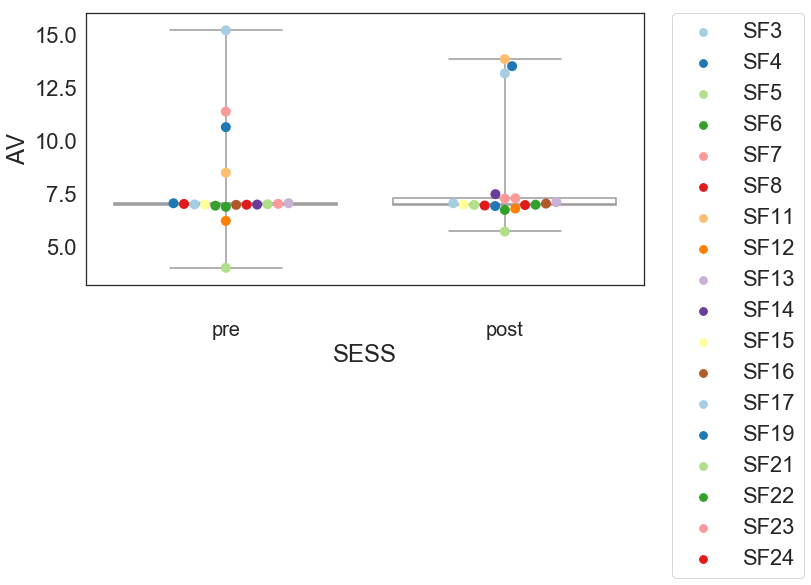

In [1378]:
sns.set_palette("Paired", 20)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x="SESS", y="AV", data=allNum.query('GROUP==1'), whis=np.inf, color='white')
ax = sns.swarmplot(x="SESS", y="AV", hue="SUBJ", data=allNum.query('GROUP==1'), size=10)

sns.set_style("white")
ax.tick_params(axis='x',pad=30,labelsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()